In [8]:
import cv2 
import numpy as np
import torch
import pandas as pd
from pathlib import Path
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.models as model
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [9]:
data_path = Path("image_dataset")

trans = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

In [10]:
data = datasets.ImageFolder(data_path, trans)
print(data.class_to_idx)
classes = ['fire', 'nofire']

train_val_size = int(len(data)*0.7)
test_size = len(data) - train_val_size

train_val_data, test_data = random_split(data, [train_val_size, test_size])
print("train_data size: ", len(train_val_data))
print("val_data size: ", len(test_data))

{'fire': 0, 'no_fire': 1}
train_data size:  1535
val_data size:  659


---

In [11]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
    
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride = 1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(16, 8, kernel_size=11, stride = 1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(8*19*19, 2)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
#
model = CNN_Model().to(device)
print(model)


Using cuda device
CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2888, out_features=2, bias=True)
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(current)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(correct)
        
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct


In [14]:

train_size = int(len(train_val_data)*0.7)
val_size = len(train_val_data) - train_size
print(train_size, val_size)

train_data, val_data = random_split(train_val_data, [train_size, val_size])

1074 461


In [15]:
batch_size = 5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

In [16]:
epoch = 3
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    tmp = val(val_loader, model, loss_fn)
    # scheduler.step()
print("Done!")

Epoch 1
-------------------------------


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0.8676789587852495
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.339580 

Epoch 2
-------------------------------
0.8872017353579176
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.284945 

Epoch 3
-------------------------------
0.8351409978308026
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.398220 

Done!


In [18]:
torch.save(model.state_dict, 'save.pt')

In [19]:
y_pred_list = []
y_list = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # print("pred: ", pred)
        # print("real: ", y)

        _, predicted = torch.max(pred.data, 1)
        # print(predicted.tolist())
        # print(y.tolist())
        y_list.extend(y.tolist())
        y_pred_list.extend(predicted.tolist())

        # total += y.size(0)
        # correct += (predicted == y).sum().item()

# print(f'Accuracy of the network on the 380 test images: {100 * correct // total} %')
##### CNN Test #####
print("##### CNN Test #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_list, y_pred_list)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_list, y_pred_list, average=None))
myTable.add_column("Recall", recall_score(y_list, y_pred_list, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_list, y_pred_list))
print(df_cm)

##### CNN Test #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.8968133535660091 | 0.8636363636363636 | 0.9253246753246753 |
| nofire | 0.8968133535660091 | 0.9300911854103343 | 0.8717948717948718 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  285   23
1   45  306


---

In [21]:
K = 3
kf = KFold(n_splits=K)
acc_sum = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_data)):
    print("---fold no {}---".format(fold))
    # print(len(train_idx))
    # print(len(val_idx))
    # print(train_idx)
    # print(val_idx)

    # train_subsampler= torch.utils.data.SubsetRandomSampler(train_idx)
    # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    train_subset= torch.utils.data.dataset.Subset(train_val_data, train_idx)
    val_subset = torch.utils.data.dataset.Subset(train_val_data, val_idx)
    # print(len(train_idx), len(val_idx), len(train_val_data))
    # print(len(train_subsampler), len(val_subsampler))
    # print(train_subsampler[0], val_subsampler[0])

    # batch_size = 5
    
    # train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_subsampler, drop_last=True) 
    # val_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=val_subsampler, drop_last = True) 
    train_loader = DataLoader(train_subset)
    val_loader = DataLoader(val_subset)
    # print(len(train_loader), len(val_loader))

    model = CNN_Model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

    epoch = 3
    for t in range(epoch):
        # print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer)
        if(t == epoch - 1):
            acc_sum += val(val_loader, model, loss_fn)
        else:
            tmp = val(val_loader, model, loss_fn)
        # scheduler.step()
    print("Done!")
print("3-Fold average accuracy: ", acc_sum / K)

---fold no 0---
0.830078125
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.405457 

0.8671875
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.337402 

0.875
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.336026 

Done!
---fold no 1---
0.86328125
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.342656 

0.8828125
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.275379 

0.8984375
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.264403 

Done!
---fold no 2---
0.9158512720156555
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.256004 

0.9197651663405088
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.229146 

0.9256360078277887
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.215709 

Done!
3-Fold average accuracy:  0.8996911692759295


In [25]:
y_pred_list = []
y_list = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # print("pred: ", pred)
        # print("real: ", y)

        _, predicted = torch.max(pred.data, 1)
        # print(predicted.tolist())
        # print(y.tolist())
        y_list.extend(y.tolist())
        y_pred_list.extend(predicted.tolist())

        # total += y.size(0)
        # correct += (predicted == y).sum().item()

# print(f'Accuracy of the network on the 380 test images: {100 * correct // total} %')
##### CNN Test #####
print("##### CNN Test #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_list, y_pred_list)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_list, y_pred_list, average=None))
myTable.add_column("Recall", recall_score(y_list, y_pred_list, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_list, y_pred_list))
print(df_cm)

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


##### CNN Test #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.9044006069802731 | 0.8746177370030581 | 0.9285714285714286 |
| nofire | 0.9044006069802731 | 0.9337349397590361 | 0.8831908831908832 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  286   22
1   41  310


---

In [23]:
from PIL import Image
from matplotlib import pyplot as plt

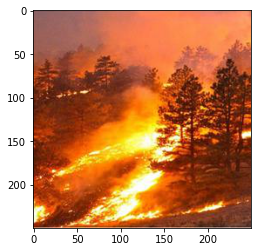

The image is predicted to be 87.34% fire


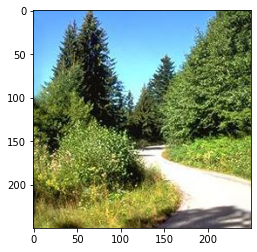

The image is predicted to be 99.9% nofire


In [24]:
fire_image_path = 'image_dataset/fire/abc064.jpg'
nofire_image_path = 'image_dataset/no_fire/abc215.jpg'

with torch.no_grad():
    ##### fire #####
    img = Image.open(fire_image_path)
    plt.imshow(img)
    plt.show()
    img_tensor = trans(img).to(device).unsqueeze(0)
    pred = model(img_tensor)
    _, predicted = torch.max(pred.data, 1)
    # print(pred)
    # print(classes[predicted])
    lab = classes[predicted]
    probs = F.softmax(pred, dim = 1)
    probs = np.round(float(probs.max())*100, 2)
    print("The image is predicted to be {}% {}".format(probs, lab))
    ##### nofire #####
    img = Image.open(nofire_image_path)
    plt.imshow(img)
    plt.show()
    img_tensor = trans(img).to(device).unsqueeze(0)
    pred = model(img_tensor)
    _, predicted = torch.max(pred.data, 1)
    # print(pred)
    # print(classes[predicted])
    lab = classes[predicted]
    probs = F.softmax(pred, dim = 1)
    probs = np.round(float(probs.max())*100, 2)
    print("The image is predicted to be {}% {}".format(probs, lab))
